# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3

train_id = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")["image_id"]
dist = pd.read_csv("distillation_label/ensemble-tta-v2.csv", header=None)
train_label = pd.DataFrame(dist.idxmax(axis=1), columns=["label"])
train = pd.concat([train_id, train_label, dist], axis=1)

test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")

display(train.head())
display(test.head())
display(label_map)

,image_id,label,0,1,2,3,4
0,1000015157.jpg,0,0.366398,0.208276,0.242890,0.032828,0.149609
1,1000201771.jpg,3,0.026702,0.035673,0.048356,0.855284,0.033985
2,100042118.jpg,4,0.035391,0.181462,0.055520,0.092377,0.635250
3,1000723321.jpg,1,0.024406,0.812886,0.036725,0.068673,0.057310
4,1000812911.jpg,3,0.028928,0.030277,0.029193,0.879340,0.032262


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

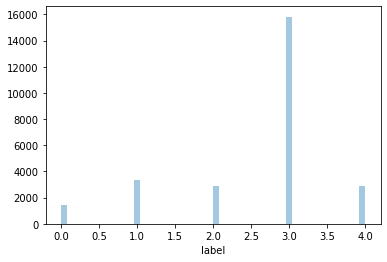

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = "vit_base_patch16_384"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 8
    gradient_accumulation_steps = 4
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    kd_temperature = 10  # DistillationLoss
    kd_alpha = 0.9  # DistillationLoss
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 5678
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         289
      1         663
      2         578
      3        3165
      4         573
1     0         289
      1         663
      2         578
      3        3165
      4         573
2     0         289
      1         663
      2         577
      3        3165
      4         573
3     0         288
      1         662
      2         578
      3        3166
      4         573
4     0         288
      1         663
      2         578
      3        3165
      4         573
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.hard_target = df["label"].values
        self.soft_target = df[[0, 1, 2, 3, 4]].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        hard_target = torch.tensor(self.hard_target[idx]).long()
        soft_target = torch.tensor(self.soft_target[idx]).float()
        return image, hard_target, soft_target


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

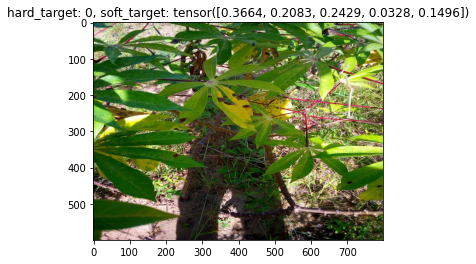

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image)
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

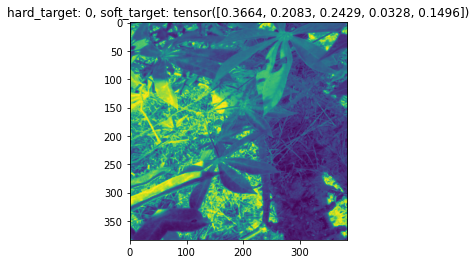

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, soft_target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]
    shuffled_soft_target = soft_target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, soft_target, shuffled_target, shuffled_soft_target, lam)

    return new_data, targets


def fmix(data, targets, soft_target, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    shuffled_soft_target = soft_target[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, soft_target, shuffled_targets, shuffled_soft_target, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, soft_target, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    shuffled_soft_target = soft_target[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, soft_target, y_b, shuffled_soft_target, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if "it_base_" in CFG.model_name:
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, hard_target, soft_target in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.4990, -0.3848, -0.2926, -0.9923,  0.4753],
        [ 0.2738,  0.7270,  0.8360,  0.9189,  0.3108],
        [-0.6176, -0.5566, -0.3044, -1.1195,  0.2256],
        [-0.4510, -0.1903, -0.0997,  0.1891, -0.4352]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

In [20]:
class DistillationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.criterion = criterion
        self.alpha = CFG.kd_alpha
        self.T = CFG.kd_temperature

    # https://github.com/peterliht/knowledge-distillation-pytorch/blob/b1e4b6acb8d4e138ad12ba1aac22d5da42a85c10/model/net.py#L100
    def forward(self, outputs, hard_target, soft_target):
        """
        Compute the knowledge-distillation (KD) loss given outputs, labels.
        "Hyperparameters": temperature and alpha
        NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
        and student expects the input tensor to be log probabilities! See Issue #2
        """
        KD_loss = nn.KLDivLoss()(F.log_softmax(outputs / self.T, dim=1), F.softmax(soft_target / self.T, dim=1)) * (
            self.alpha * self.T * self.T
        ) + self.criterion(outputs, hard_target) * (1.0 - self.alpha)

        return KD_loss

# Helper functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, hard_target, soft_target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, hard_target, soft_target, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(
                images, hard_target, soft_target, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size)
            )
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, hard_target, soft_target, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0], labels[1]) * labels[4] + criterion(y_preds, labels[2], labels[3]) * (
                1.0 - labels[4]
            )
        else:
            loss = criterion(y_preds, hard_target, soft_target)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, hard_target, soft_target) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, hard_target, soft_target)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            hard_criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            hard_criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)

        criterion = DistillationLoss(hard_criterion)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [24]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/2633] Elapsed 0m 4s (remain 182m 10s) Loss: 0.0580(0.0580) Grad: 0.2045 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 45s (remain 44m 0s) Loss: 0.0221(0.0393) Grad: 0.0740 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 3m 26s (remain 41m 37s) Loss: 0.0225(0.0319) Grad: 0.0664 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 5m 7s (remain 39m 42s) Loss: 0.0178(0.0289) Grad: 0.0296 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 6m 48s (remain 37m 53s) Loss: 0.0181(0.0269) Grad: 0.0408 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 8m 29s (remain 36m 8s) Loss: 0.0173(0.0254) Grad: 0.0287 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 10m 10s (remain 34m 24s) Loss: 0.0140(0.0243) Grad: 0.0439 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 11m 51s (remain 32m 41s) Loss: 0.0194(0.0236) Grad: 0.0329 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 13m 32s (remain 30m 58s) Loss: 0.0175(0.0230) Grad: 0.0382 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 15m 13s (remain 29m 16s) Loss: 0.0161(0.0223) Grad: 0.0

Epoch 1 - avg_train_loss: 0.0189  avg_val_loss: 0.0170  time: 2914s
Epoch 1 - Accuracy: 0.9130599848139711
Epoch 1 - Save Best Score: 0.9131 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0153(0.0170) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 63m 34s) Loss: 0.0153(0.0153) Grad: 0.0541 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 42s (remain 42m 57s) Loss: 0.0148(0.0156) Grad: 0.0181 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 3m 24s (remain 41m 10s) Loss: 0.0142(0.0154) Grad: 0.0227 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 5m 5s (remain 39m 27s) Loss: 0.0149(0.0155) Grad: 0.0151 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 6m 46s (remain 37m 44s) Loss: 0.0146(0.0155) Grad: 0.0332 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 8m 28s (remain 36m 3s) Loss: 0.0131(0.0155) Grad: 0.0171 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 10m 9s (remain 34m 21s) Loss: 0.0145(0.0155) Grad: 0.0322 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 11m 51s (remain 32m 39s) Loss: 0.0130(0.0155) Grad: 0.0155 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 13m 32s (remain 30m 57s) Loss: 0.0208(0.0156) Grad: 0.0615 LR: 0.000096  
Epoch: [2][900/26

Epoch 2 - avg_train_loss: 0.0158  avg_val_loss: 0.0167  time: 2921s
Epoch 2 - Accuracy: 0.9227410782080486
Epoch 2 - Save Best Score: 0.9227 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0240(0.0167) 
Epoch: [3][0/2633] Elapsed 0m 1s (remain 66m 17s) Loss: 0.0161(0.0161) Grad: 0.0380 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 43s (remain 43m 17s) Loss: 0.0199(0.0227) Grad: 0.0423 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 3m 25s (remain 41m 27s) Loss: 0.0180(0.0224) Grad: 0.0280 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 5m 7s (remain 39m 44s) Loss: 0.0260(0.0226) Grad: 0.0494 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 6m 49s (remain 38m 0s) Loss: 0.0221(0.0224) Grad: 0.0634 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 8m 31s (remain 36m 18s) Loss: 0.0266(0.0224) Grad: 0.0411 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 10m 13s (remain 34m 35s) Loss: 0.0206(0.0224) Grad: 0.0430 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 11m 55s (remain 32m 52s) Loss: 0.0168(0.0224) Grad: 0.0406 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 13m 37s (remain 31m 10s) Loss: 0.0180(0.0226) Grad: 0.0369 LR: 0.000088  
Epoch: [3][900/2

Epoch 3 - avg_train_loss: 0.0222  avg_val_loss: 0.0160  time: 2936s
Epoch 3 - Accuracy: 0.9343204252088079
Epoch 3 - Save Best Score: 0.9343 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0245(0.0160) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 65m 3s) Loss: 0.0145(0.0145) Grad: 0.0389 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 43s (remain 43m 13s) Loss: 0.0144(0.0212) Grad: 0.0405 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 3m 25s (remain 41m 23s) Loss: 0.0222(0.0216) Grad: 0.0551 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 5m 7s (remain 39m 41s) Loss: 0.0196(0.0217) Grad: 0.0327 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 6m 49s (remain 37m 58s) Loss: 0.0224(0.0217) Grad: 0.0132 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 8m 31s (remain 36m 15s) Loss: 0.0191(0.0218) Grad: 0.0238 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 10m 13s (remain 34m 33s) Loss: 0.0247(0.0217) Grad: 0.0427 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 11m 55s (remain 32m 51s) Loss: 0.0174(0.0217) Grad: 0.0429 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 13m 37s (remain 31m 9s) Loss: 0.0226(0.0217) Grad: 0.0202 LR: 0.000076  
Epoch: [4][900/26

Epoch 4 - avg_train_loss: 0.0216  avg_val_loss: 0.0164  time: 2935s
Epoch 4 - Accuracy: 0.9299544419134397


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0227(0.0164) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 64m 31s) Loss: 0.0169(0.0169) Grad: 0.0286 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 43s (remain 43m 11s) Loss: 0.0194(0.0224) Grad: 0.0369 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 3m 25s (remain 41m 26s) Loss: 0.0132(0.0221) Grad: 0.0200 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 5m 7s (remain 39m 43s) Loss: 0.0254(0.0219) Grad: 0.0410 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 6m 49s (remain 38m 0s) Loss: 0.0169(0.0218) Grad: 0.0419 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 8m 31s (remain 36m 17s) Loss: 0.0182(0.0218) Grad: 0.0271 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 10m 13s (remain 34m 34s) Loss: 0.0270(0.0217) Grad: 0.0383 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 11m 55s (remain 32m 52s) Loss: 0.0165(0.0217) Grad: 0.0207 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 13m 37s (remain 31m 10s) Loss: 0.0290(0.0217) Grad: 0.0357 LR: 0.000062  
Epoch: [5][900/2

Epoch 5 - avg_train_loss: 0.0214  avg_val_loss: 0.0162  time: 2936s
Epoch 5 - Accuracy: 0.9331814730447988


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0187(0.0162) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 65m 57s) Loss: 0.0139(0.0139) Grad: 0.0395 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 43s (remain 43m 13s) Loss: 0.0223(0.0212) Grad: 0.0577 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 3m 25s (remain 41m 24s) Loss: 0.0200(0.0210) Grad: 0.0453 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 5m 7s (remain 39m 40s) Loss: 0.0216(0.0208) Grad: 0.0213 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 6m 49s (remain 37m 57s) Loss: 0.0196(0.0207) Grad: 0.0338 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 8m 31s (remain 36m 16s) Loss: 0.0224(0.0210) Grad: 0.0297 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 10m 13s (remain 34m 33s) Loss: 0.0191(0.0211) Grad: 0.0356 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 11m 55s (remain 32m 51s) Loss: 0.0309(0.0211) Grad: 0.0275 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 13m 36s (remain 31m 8s) Loss: 0.0183(0.0210) Grad: 0.0255 LR: 0.000046  
Epoch: [6][900/2

Epoch 6 - avg_train_loss: 0.0209  avg_val_loss: 0.0158  time: 2934s
Epoch 6 - Accuracy: 0.9371678056188307
Epoch 6 - Save Best Score: 0.9372 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0225(0.0158) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 66m 5s) Loss: 0.0167(0.0167) Grad: 0.0322 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 43s (remain 43m 7s) Loss: 0.0164(0.0184) Grad: 0.0208 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 3m 24s (remain 41m 17s) Loss: 0.0144(0.0182) Grad: 0.0163 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 5m 6s (remain 39m 32s) Loss: 0.0134(0.0181) Grad: 0.0087 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 6m 47s (remain 37m 50s) Loss: 0.0236(0.0181) Grad: 0.0179 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 8m 29s (remain 36m 8s) Loss: 0.0171(0.0183) Grad: 0.0250 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 10m 11s (remain 34m 26s) Loss: 0.0160(0.0183) Grad: 0.0300 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 11m 52s (remain 32m 44s) Loss: 0.0170(0.0181) Grad: 0.0289 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 13m 34s (remain 31m 2s) Loss: 0.0288(0.0183) Grad: 0.0330 LR: 0.000032  
Epoch: [7][900/2633

Epoch 7 - avg_train_loss: 0.0182  avg_val_loss: 0.0156  time: 2926s
Epoch 7 - Accuracy: 0.9419134396355353
Epoch 7 - Save Best Score: 0.9419 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0174(0.0156) 
Epoch: [8][0/2633] Elapsed 0m 1s (remain 65m 24s) Loss: 0.0159(0.0159) Grad: 0.0351 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 43s (remain 43m 7s) Loss: 0.0143(0.0183) Grad: 0.0177 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 3m 24s (remain 41m 16s) Loss: 0.0141(0.0177) Grad: 0.0205 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 5m 6s (remain 39m 32s) Loss: 0.0150(0.0181) Grad: 0.0113 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 6m 47s (remain 37m 49s) Loss: 0.0259(0.0180) Grad: 0.0370 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 8m 29s (remain 36m 7s) Loss: 0.0132(0.0181) Grad: 0.0052 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 10m 10s (remain 34m 25s) Loss: 0.0155(0.0181) Grad: 0.0095 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 11m 52s (remain 32m 43s) Loss: 0.0157(0.0181) Grad: 0.0128 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 13m 33s (remain 31m 1s) Loss: 0.0124(0.0180) Grad: 0.0079 LR: 0.000019  
Epoch: [8][900/263

Epoch 8 - avg_train_loss: 0.0180  avg_val_loss: 0.0154  time: 2924s
Epoch 8 - Accuracy: 0.9458997722095672
Epoch 8 - Save Best Score: 0.9459 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0214(0.0154) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 64m 30s) Loss: 0.0127(0.0127) Grad: 0.0045 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 43s (remain 43m 4s) Loss: 0.0192(0.0173) Grad: 0.0353 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 3m 24s (remain 41m 17s) Loss: 0.0158(0.0175) Grad: 0.0352 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 5m 6s (remain 39m 33s) Loss: 0.0275(0.0174) Grad: 0.0169 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 6m 47s (remain 37m 50s) Loss: 0.0132(0.0176) Grad: 0.0079 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 8m 29s (remain 36m 8s) Loss: 0.0225(0.0177) Grad: 0.0308 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 10m 11s (remain 34m 26s) Loss: 0.0128(0.0176) Grad: 0.0125 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 11m 52s (remain 32m 44s) Loss: 0.0180(0.0175) Grad: 0.0285 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 13m 34s (remain 31m 2s) Loss: 0.0181(0.0176) Grad: 0.0306 LR: 0.000009  
Epoch: [9][900/263

Epoch 9 - avg_train_loss: 0.0177  avg_val_loss: 0.0154  time: 2925s
Epoch 9 - Accuracy: 0.9466590736522399
Epoch 9 - Save Best Score: 0.9467 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0178(0.0154) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 64m 20s) Loss: 0.0157(0.0157) Grad: 0.0398 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 42s (remain 42m 56s) Loss: 0.0149(0.0143) Grad: 0.0080 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 3m 24s (remain 41m 9s) Loss: 0.0152(0.0144) Grad: 0.0071 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 5m 5s (remain 39m 25s) Loss: 0.0168(0.0145) Grad: 0.0284 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 6m 46s (remain 37m 43s) Loss: 0.0155(0.0145) Grad: 0.0391 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 8m 27s (remain 36m 1s) Loss: 0.0134(0.0144) Grad: 0.0092 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 10m 9s (remain 34m 19s) Loss: 0.0157(0.0144) Grad: 0.0208 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 11m 50s (remain 32m 37s) Loss: 0.0125(0.0144) Grad: 0.0054 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 13m 31s (remain 30m 56s) Loss: 0.0138(0.0144) Grad: 0.0067 LR: 0.000003  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0143  avg_val_loss: 0.0152  time: 2917s
Epoch 10 - Accuracy: 0.9510250569476082
Epoch 10 - Save Best Score: 0.9510 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0187(0.0152) 


Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.95103
========== fold: 1 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 62m 50s) Loss: 0.0542(0.0542) Grad: 0.2647 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 42s (remain 42m 49s) Loss: 0.0199(0.0366) Grad: 0.0769 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 3m 23s (remain 41m 2s) Loss: 0.0182(0.0305) Grad: 0.0625 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 5m 4s (remain 39m 19s) Loss: 0.0207(0.0275) Grad: 0.0477 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 6m 45s (remain 37m 37s) Loss: 0.0173(0.0254) Grad: 0.0498 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 8m 26s (remain 35m 55s) Loss: 0.0155(0.0240) Grad: 0.0159 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 10m 7s (remain 34m 14s) Loss: 0.0164(0.0230) Grad: 0.0402 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 11m 48s (remain 32m 33s) Loss: 0.0179(0.0224) Grad: 0.0529 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 13m 29s (remain 30m 51s) Loss: 0.0185(0.0218) Grad: 0.0333 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 15m 10s (remain 29m 10s) Loss: 0.0161(0.0213) Grad: 0.05

Epoch 1 - avg_train_loss: 0.0185  avg_val_loss: 0.0172  time: 2911s
Epoch 1 - Accuracy: 0.922171602126044
Epoch 1 - Save Best Score: 0.9222 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0153(0.0172) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 63m 55s) Loss: 0.0160(0.0160) Grad: 0.0623 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 42s (remain 42m 57s) Loss: 0.0141(0.0160) Grad: 0.0261 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 3m 24s (remain 41m 9s) Loss: 0.0173(0.0157) Grad: 0.0380 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 5m 5s (remain 39m 25s) Loss: 0.0207(0.0156) Grad: 0.0752 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 6m 46s (remain 37m 43s) Loss: 0.0133(0.0155) Grad: 0.0222 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 8m 27s (remain 36m 1s) Loss: 0.0178(0.0155) Grad: 0.0470 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 10m 9s (remain 34m 19s) Loss: 0.0130(0.0154) Grad: 0.0215 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 11m 50s (remain 32m 37s) Loss: 0.0151(0.0155) Grad: 0.0221 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 13m 31s (remain 30m 56s) Loss: 0.0134(0.0155) Grad: 0.0244 LR: 0.000096  
Epoch: [2][900/263

Epoch 2 - avg_train_loss: 0.0156  avg_val_loss: 0.0161  time: 2917s
Epoch 2 - Accuracy: 0.9320425208807896
Epoch 2 - Save Best Score: 0.9320 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 65m 36s) Loss: 0.0279(0.0279) Grad: 0.0426 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 43s (remain 43m 10s) Loss: 0.0185(0.0219) Grad: 0.0290 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 3m 25s (remain 41m 23s) Loss: 0.0230(0.0223) Grad: 0.0327 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 5m 7s (remain 39m 41s) Loss: 0.0246(0.0227) Grad: 0.0358 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 6m 49s (remain 37m 58s) Loss: 0.0318(0.0226) Grad: 0.0573 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 8m 31s (remain 36m 15s) Loss: 0.0244(0.0224) Grad: 0.0413 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 10m 13s (remain 34m 32s) Loss: 0.0151(0.0222) Grad: 0.0321 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 11m 54s (remain 32m 50s) Loss: 0.0168(0.0222) Grad: 0.0217 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 13m 36s (remain 31m 8s) Loss: 0.0308(0.0221) Grad: 0.0355 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 15m 18s (remain 29m 26s) Loss: 0.0178(0.0220) Grad: 0.0

Epoch 3 - avg_train_loss: 0.0220  avg_val_loss: 0.0165  time: 2935s
Epoch 3 - Accuracy: 0.9240698557327259


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0135(0.0165) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 66m 34s) Loss: 0.0301(0.0301) Grad: 0.0590 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 43s (remain 43m 14s) Loss: 0.0193(0.0211) Grad: 0.0237 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 3m 25s (remain 41m 26s) Loss: 0.0264(0.0214) Grad: 0.0441 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 5m 7s (remain 39m 42s) Loss: 0.0170(0.0219) Grad: 0.0397 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 6m 49s (remain 37m 58s) Loss: 0.0289(0.0219) Grad: 0.0676 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 8m 31s (remain 36m 16s) Loss: 0.0184(0.0220) Grad: 0.0409 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 10m 13s (remain 34m 34s) Loss: 0.0163(0.0220) Grad: 0.0691 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 11m 55s (remain 32m 51s) Loss: 0.0337(0.0220) Grad: 0.0254 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 13m 37s (remain 31m 9s) Loss: 0.0248(0.0220) Grad: 0.0577 LR: 0.000076  
Epoch: [4][900/2

Epoch 4 - avg_train_loss: 0.0215  avg_val_loss: 0.0163  time: 2935s
Epoch 4 - Accuracy: 0.9335611237661352
Epoch 4 - Save Best Score: 0.9336 Model


Epoch: [5][0/2633] Elapsed 0m 1s (remain 69m 6s) Loss: 0.0304(0.0304) Grad: 0.0714 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 43s (remain 43m 15s) Loss: 0.0194(0.0205) Grad: 0.0349 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 3m 25s (remain 41m 26s) Loss: 0.0133(0.0210) Grad: 0.0161 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 5m 7s (remain 39m 43s) Loss: 0.0157(0.0211) Grad: 0.0352 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 6m 49s (remain 37m 59s) Loss: 0.0229(0.0208) Grad: 0.0613 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 8m 31s (remain 36m 15s) Loss: 0.0155(0.0210) Grad: 0.0277 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 10m 13s (remain 34m 34s) Loss: 0.0136(0.0210) Grad: 0.0183 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 11m 55s (remain 32m 51s) Loss: 0.0237(0.0211) Grad: 0.0594 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 13m 37s (remain 31m 8s) Loss: 0.0214(0.0211) Grad: 0.0383 LR: 0.000062  
Epoch: [5][900/2633] Elapsed 15m 18s (remain 29m 26s) Loss: 0.0140(0.0211) Grad: 0.02

Epoch 5 - avg_train_loss: 0.0212  avg_val_loss: 0.0162  time: 2935s


EVAL: [658/659] Elapsed 4m 9s (remain 0m 0s) Loss: 0.0132(0.0162) 


Epoch 5 - Accuracy: 0.9310933940774487


Epoch: [6][0/2633] Elapsed 0m 1s (remain 66m 30s) Loss: 0.0125(0.0125) Grad: 0.0264 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 43s (remain 43m 14s) Loss: 0.0192(0.0214) Grad: 0.0124 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 3m 25s (remain 41m 25s) Loss: 0.0292(0.0211) Grad: 0.0349 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 5m 7s (remain 39m 40s) Loss: 0.0169(0.0208) Grad: 0.0318 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 6m 49s (remain 37m 57s) Loss: 0.0208(0.0209) Grad: 0.0224 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 8m 31s (remain 36m 14s) Loss: 0.0167(0.0212) Grad: 0.0293 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 10m 12s (remain 34m 32s) Loss: 0.0257(0.0212) Grad: 0.0299 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 11m 54s (remain 32m 50s) Loss: 0.0152(0.0211) Grad: 0.0307 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 13m 36s (remain 31m 8s) Loss: 0.0167(0.0211) Grad: 0.0213 LR: 0.000046  
Epoch: [6][900/2633] Elapsed 15m 18s (remain 29m 26s) Loss: 0.0200(0.0210) Grad: 0.0

Epoch 6 - avg_train_loss: 0.0209  avg_val_loss: 0.0162  time: 2934s
Epoch 6 - Accuracy: 0.9288154897494305


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0129(0.0162) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 66m 7s) Loss: 0.0264(0.0264) Grad: 0.0232 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 42s (remain 43m 0s) Loss: 0.0152(0.0188) Grad: 0.0295 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 3m 24s (remain 41m 14s) Loss: 0.0172(0.0188) Grad: 0.0227 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 5m 6s (remain 39m 31s) Loss: 0.0243(0.0189) Grad: 0.0525 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 6m 47s (remain 37m 48s) Loss: 0.0168(0.0187) Grad: 0.0312 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 8m 29s (remain 36m 6s) Loss: 0.0208(0.0187) Grad: 0.0519 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 10m 10s (remain 34m 24s) Loss: 0.0143(0.0186) Grad: 0.0171 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 11m 52s (remain 32m 42s) Loss: 0.0143(0.0185) Grad: 0.0182 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 13m 33s (remain 31m 1s) Loss: 0.0139(0.0184) Grad: 0.0190 LR: 0.000032  
Epoch: [7][900/2633

Epoch 7 - avg_train_loss: 0.0183  avg_val_loss: 0.0156  time: 2924s
Epoch 7 - Accuracy: 0.9398253606681852
Epoch 7 - Save Best Score: 0.9398 Model


Epoch: [8][0/2633] Elapsed 0m 1s (remain 65m 29s) Loss: 0.0156(0.0156) Grad: 0.0281 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 43s (remain 43m 4s) Loss: 0.0138(0.0175) Grad: 0.0059 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 3m 24s (remain 41m 13s) Loss: 0.0165(0.0176) Grad: 0.0231 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 5m 6s (remain 39m 31s) Loss: 0.0259(0.0181) Grad: 0.0270 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 6m 47s (remain 37m 49s) Loss: 0.0199(0.0182) Grad: 0.0354 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 8m 29s (remain 36m 6s) Loss: 0.0324(0.0181) Grad: 0.0395 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 10m 10s (remain 34m 25s) Loss: 0.0172(0.0182) Grad: 0.0348 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 11m 52s (remain 32m 43s) Loss: 0.0241(0.0181) Grad: 0.0323 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 13m 33s (remain 31m 1s) Loss: 0.0183(0.0180) Grad: 0.0199 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 15m 15s (remain 29m 19s) Loss: 0.0127(0.0180) Grad: 0.008

Epoch 8 - avg_train_loss: 0.0180  avg_val_loss: 0.0154  time: 2925s
Epoch 8 - Accuracy: 0.9460895975702354
Epoch 8 - Save Best Score: 0.9461 Model


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0126(0.0154) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 66m 6s) Loss: 0.0156(0.0156) Grad: 0.0216 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 43s (remain 43m 6s) Loss: 0.0271(0.0174) Grad: 0.0269 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 3m 24s (remain 41m 15s) Loss: 0.0244(0.0179) Grad: 0.0223 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 5m 6s (remain 39m 32s) Loss: 0.0309(0.0178) Grad: 0.0274 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 6m 47s (remain 37m 49s) Loss: 0.0135(0.0178) Grad: 0.0027 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 8m 29s (remain 36m 7s) Loss: 0.0160(0.0179) Grad: 0.0286 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 10m 10s (remain 34m 25s) Loss: 0.0163(0.0177) Grad: 0.0302 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 11m 52s (remain 32m 43s) Loss: 0.0167(0.0177) Grad: 0.0363 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 13m 33s (remain 31m 1s) Loss: 0.0129(0.0177) Grad: 0.0056 LR: 0.000009  
Epoch: [9][900/2633

Epoch 9 - avg_train_loss: 0.0178  avg_val_loss: 0.0153  time: 2926s
Epoch 9 - Accuracy: 0.9453302961275627


EVAL: [658/659] Elapsed 4m 10s (remain 0m 0s) Loss: 0.0125(0.0153) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 67m 19s) Loss: 0.0138(0.0138) Grad: 0.0234 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 42s (remain 43m 1s) Loss: 0.0144(0.0144) Grad: 0.0073 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 3m 24s (remain 41m 13s) Loss: 0.0140(0.0143) Grad: 0.0035 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 5m 5s (remain 39m 29s) Loss: 0.0147(0.0144) Grad: 0.0076 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 6m 47s (remain 37m 47s) Loss: 0.0135(0.0144) Grad: 0.0030 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 8m 28s (remain 36m 4s) Loss: 0.0161(0.0144) Grad: 0.0228 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 10m 10s (remain 34m 23s) Loss: 0.0136(0.0143) Grad: 0.0042 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 11m 51s (remain 32m 41s) Loss: 0.0135(0.0143) Grad: 0.0070 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 13m 33s (remain 30m 59s) Loss: 0.0140(0.0143) Grad: 0.0124 LR: 0.000003  
Epoch: [

Epoch 10 - avg_train_loss: 0.0143  avg_val_loss: 0.0152  time: 2922s
Epoch 10 - Accuracy: 0.9462794229309036
Epoch 10 - Save Best Score: 0.9463 Model
Epoch 10 - Save final model
========== fold: 1 result ==========
Score: 0.94628
========== fold: 2 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 64m 16s) Loss: 0.1260(0.1260) Grad: 0.4337 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 42s (remain 42m 51s) Loss: 0.0326(0.0342) Grad: 0.0486 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 3m 23s (remain 41m 2s) Loss: 0.0215(0.0293) Grad: 0.0703 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 5m 4s (remain 39m 19s) Loss: 0.0274(0.0265) Grad: 0.0857 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 6m 45s (remain 37m 37s) Loss: 0.0228(0.0249) Grad: 0.0641 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 8m 26s (remain 35m 56s) Loss: 0.0159(0.0237) Grad: 0.0418 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 10m 7s (remain 34m 14s) Loss: 0.0168(0.0229) Grad: 0.0538 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 11m 48s (remain 32m 33s) Loss: 0.0164(0.0222) Grad: 0.0496 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 13m 29s (remain 30m 52s) Loss: 0.0273(0.0216) Grad: 0.0748 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 15m 10s (remain 29m 11s) Loss: 0.0213(0.0212) Grad: 0.07

KeyboardInterrupt: 